<a href="https://colab.research.google.com/github/Lupercio421/STAT-725/blob/main/dsny_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to install new packages with [pip](https://ayoolafelix.hashnode.dev/how-to-permanently-install-a-module-on-google-colab-ckixqrvs40su044s187y274tc

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

from google.colab import drive
drive.mount('/content/gdrive')

sys.path.append('/content/gdrive/My Drive/Colab Notebooks')


# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

from pathlib import Path
import pandas as pd
import statsmodels as sm
#!pip install --target=$nb_path chart_studio
import chart_studio.plotly as py
import plotly.express as px
#!pip install --target=$nb_path skimpy
from skimpy import skim, generate_test_data

# Socrata import
#!pip install --target=$nb_path sodapy
from sodapy import Socrata

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline 
#show our charts inside jupyter notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Mounted at /content/gdrive


In [3]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("ebb7-mvp5", limit = 25000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
results_df.head()

,month,borough,communitydistrict,refusetonscollected,papertonscollected,mgptonscollected,borough_id,leavesorganictons,schoolorganictons,resorganicstons,xmastreetons
0,2022 / 01,Bronx,01,412.310000000000002,21.990000000000002,28.140000000000001,2,NaN,NaN,NaN,NaN
1,2022 / 01,Bronx,02,296.150000000000034,12.420000000000000,20.789999999999999,2,3.000000000000000,NaN,NaN,NaN
2,2022 / 01,Bronx,03,426.540000000000020,32.980000000000004,47.300000000000004,2,NaN,NaN,NaN,NaN
3,2022 / 01,Bronx,04,740.289999999999964,58.300000000000004,67.670000000000002,2,NaN,NaN,NaN,NaN
4,2022 / 01,Bronx,05,596.259999999999991,38.500000000000000,60.770000000000003,2,NaN,NaN,NaN,NaN


In [4]:
(results_df[(results_df['communitydistrict'] == '7A')]) 
#index = 115, 765, 825, 885

#Drop the rows where CD == '7A' by their index, no need to assign the dataframe once again
results_df.drop([115, 765, 825, 885], inplace=True)

Try this [article](https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-index-labels/#:~:text=Delete%20a%20Multiple%20Rows%20by%20Index%20Position%20in%20DataFrame&text=As%20df.,pass%20it%20to%20drop(). when you come back to this 

In [5]:
from pandas.core.frame import DataFrame
def clean_columns(df = DataFrame):
  df['month'] = pd.to_datetime(results_df['month'])
  df['borough'] = df['borough'].astype(str)
  df['community_district'] = df['communitydistrict'].astype(int)
  df['refuse_tons_collected'] = df['refusetonscollected'].astype(float)
  df['paper_tons_collected'] = df['papertonscollected'].astype(float)
  df['mgp_tons_collected'] = df['mgptonscollected'].astype(float)
  df['leaves_organic_tons'] = df['leavesorganictons'].astype(float)
  df['school_organic_tons'] = df['schoolorganictons'].astype(float)
  df['res_organics_tons'] = df['resorganicstons'].astype(float)
  df['xmas_tree_tons'] = df['xmastreetons'].astype(float)
  return(df)

In [6]:
dsny_1 = clean_columns(results_df)
print(dsny_1.dtypes)

month                    datetime64[ns]
borough                          object
communitydistrict                object
refusetonscollected              object
papertonscollected               object
mgptonscollected                 object
borough_id                       object
leavesorganictons                object
schoolorganictons                object
resorganicstons                  object
xmastreetons                     object
community_district                int64
refuse_tons_collected           float64
paper_tons_collected            float64
mgp_tons_collected              float64
leaves_organic_tons             float64
school_organic_tons             float64
res_organics_tons               float64
xmas_tree_tons                  float64
dtype: object


In [6]:
#dsny_1.head()
#C:\Users\Daniel\Desktop\PowerBI_Udemy
#dsny_1.to_csv("C:\\Users\\Daniel\\Desktop\\PowerBI_Udemy\\DSNY_data.csv", header=True,)

## The next goal is to create a series
When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [batch size, time steps, dimensionality], where dimensionality is 1 for univariate time series and more for multivariate time series.


Indexing the dataframe right away with the month will not work as nicely. The indices will not be distinct

In [7]:
dsny_1[['month', 'borough','community_district','refuse_tons_collected']]
dsny_1.iloc[20]
dsny_qns_3 = dsny_1[(dsny_1['borough'] == 'Queens') & (dsny_1['community_district'] == 3) & (dsny_1['month'] < '01-01-2022')]
dsny_qns_3[dsny_qns_3['refuse_tons_collected'] > 3000]
dsny_qns_3.iloc[:,:4]
dsny_qns_3_refuse = dsny_qns_3[['month', 'refuse_tons_collected']]
dsny_qns_3_refuse.sort_values(by="month",inplace = True) #from 04/1991 to 12/2021
#dsny_qns_3_refuse.iloc[:300]
#dsny_qns_3_refuse.iloc[:300,-1] 

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [8]:
px.line(dsny_qns_3, x = 'month', y = 'refuse_tons_collected',
        labels = {'x':'Month', 'y':'Tons'})


### Moving Averages

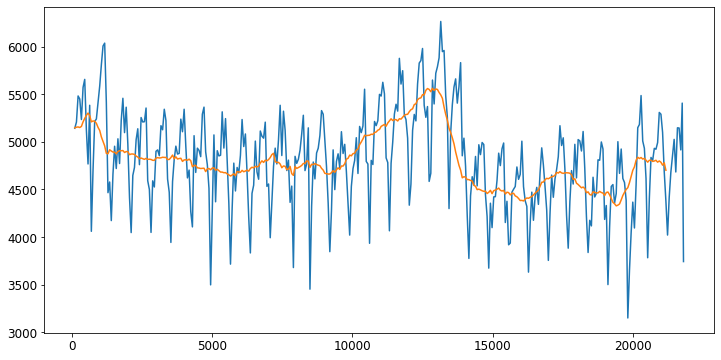

In [9]:
dsny_qns_3_refuse['refuse_tons_collected'].plot(figsize = (12,6))
dsny_qns_3_refuse.rolling(window = 12).mean()['refuse_tons_collected'].plot(figsize = (12,6))

In [ ]:
# n_steps = 50
# series = generate_time_series(10000, n_steps + 1)
# X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
# X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
# X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
# dsny_qns_3_refuse[:200,:51]

In [10]:
dsny_qns_3_refuse.tail(), dsny_qns_3_refuse.head()

(         month  refuse_tons_collected
 340 2021-08-01                5233.71
 281 2021-09-01                5449.19
 222 2021-10-01                5480.95
 163 2021-11-01                5206.84
 103 2021-12-01                5141.92,            month  refuse_tons_collected
 21797 1991-04-01                3742.30
 21752 1991-05-01                5406.05
 21700 1991-06-01                4914.80
 21641 1991-07-01                5144.50
 21582 1991-08-01                5146.67)

uncomment the second line on the next run

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



369


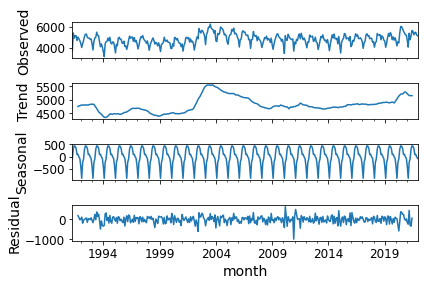

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
dsny_qns_3_refuse.set_index("month", inplace=True) 
results = seasonal_decompose(dsny_qns_3_refuse['refuse_tons_collected']) #'Int64Index' object has no attribute 'inferred_freq'
results.plot();
print(len(dsny_qns_3_refuse))

train = dsny_qns_3_refuse.iloc[:200]
test = dsny_qns_3_refuse.iloc[200:]

In [11]:
print(train.head(), train.tail())
print()
print(test.head(), test.tail())

            refuse_tons_collected
month                            
1991-04-01                3742.30
1991-05-01                5406.05
1991-06-01                4914.80
1991-07-01                5144.50
1991-08-01                5146.67             refuse_tons_collected
month                            
2007-07-01                5096.30
2007-08-01                5160.95
2007-09-01                4667.24
2007-10-01                5042.72
2007-11-01                4804.41

            refuse_tons_collected
month                            
2007-12-01                4718.33
2008-01-01                4530.14
2008-02-01                4020.15
2008-03-01                4361.61
2008-04-01                4686.41             refuse_tons_collected
month                            
2021-08-01                5233.71
2021-09-01                5449.19
2021-10-01                5480.95
2021-11-01                5206.84
2021-12-01                5141.92


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.preprocessing.sequence import TimeseriesGenerator
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#define generator
n_input = 12 #12 values per year, for the refuse waste stream
n_features = 1 #just one waste stream
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1) #used on the training set

In [13]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')
print(X.shape)

Given the Array: 
[0.19025257 0.72466538 0.56687106 0.64065296 0.64134998 0.49238251
 0.60226838 0.54801605 0.49077646 0.40687646 0.27967738 0.39444564]
Predict this y: 
 [[0.4931245]]
(1, 12, 1)


This now takes 4 minutes to run because I switched a setting to use the GPU on this notebook

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(generator,epochs=50)

Epoch 1/50
188/188 [==============================] - 6s 13ms/step - loss: 0.0369
Epoch 2/50
188/188 [==============================] - 3s 14ms/step - loss: 0.0232
Epoch 3/50
188/188 [==============================] - 3s 16ms/step - loss: 0.0204
Epoch 4/50
188/188 [==============================] - 3s 14ms/step - loss: 0.0187
Epoch 5/50
188/188 [==============================] - 3s 16ms/step - loss: 0.0143
Epoch 6/50
188/188 [==============================] - 3s 16ms/step - loss: 0.0138
Epoch 7/50
188/188 [==============================] - 3s 13ms/step - loss: 0.0133
Epoch 8/50
188/188 [==============================] - 3s 14ms/step - loss: 0.0124
Epoch 9/50
188/188 [==============================] - 3s 14ms/step - loss: 0.0163
Epoch 10/50
188/188 [==============================] - 2s 12ms/step - loss: 0.0121
Epoch 11/50
188/188 [==============================] - 1s 8ms/step - loss: 0.0110
Epoch 12/50
188/188 [==============================] - 1s 6ms/step - loss: 0.0103
Epoch 13/50
188

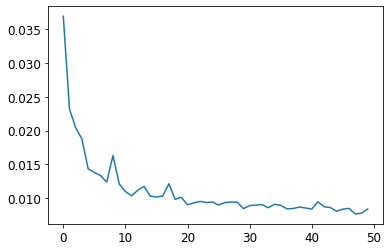

In [32]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [33]:
last_train_batch = scaled_train[-12:] #get the last 12 month values
last_train_batch = last_train_batch.reshape((1, n_input, n_features)) #reshape them as an array, containing 12 values, with each value being a list of 1
model.predict(last_train_batch)

array([[0.48767197]], dtype=float32)

In [21]:
#last_train_batch.reshape((1, n_input, n_features))

array([[[0.51759105],
        [0.5314898 ],
        [0.25185418],
        [0.51920032],
        [0.52803359],
        [0.7714785 ],
        [0.64753327],
        [0.62517064],
        [0.64593686],
        [0.48735236],
        [0.60796022],
        [0.53141271]]])

In [34]:
scaled_test[0]

array([0.50376297])

In [35]:
scaled_train[-n_input:] #this is the same as the last_train_batch.reshape((1, n_input, n_features))

array([[0.51759105],
       [0.5314898 ],
       [0.25185418],
       [0.51920032],
       [0.52803359],
       [0.7714785 ],
       [0.64753327],
       [0.62517064],
       [0.64593686],
       [0.48735236],
       [0.60796022],
       [0.53141271]])

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
  #get the prediction value for the first batch
  current_pred = model.predict(current_batch)[0]

  #append the prediction into the array
  test_predictions.append(current_pred)

  #use the prediction to update the batch and remove the first value
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)


In [37]:
first_eval_batch.reshape((1, n_input, n_features))

array([[[0.51759105],
        [0.5314898 ],
        [0.25185418],
        [0.51920032],
        [0.52803359],
        [0.7714785 ],
        [0.64753327],
        [0.62517064],
        [0.64593686],
        [0.48735236],
        [0.60796022],
        [0.53141271]]])

In [26]:
#test_predictions

In [41]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,refuse_tons_collected,Predictions,Predictions_LSTM
month,,,
2007-12-01,4718.33,4668.235011,4668.235011
2008-01-01,4530.14,4410.717775,4410.717775
2008-02-01,4020.15,4151.010804,4151.010804
2008-03-01,4361.61,4489.000761,4489.000761
2008-04-01,4686.41,4751.954157,4751.954157


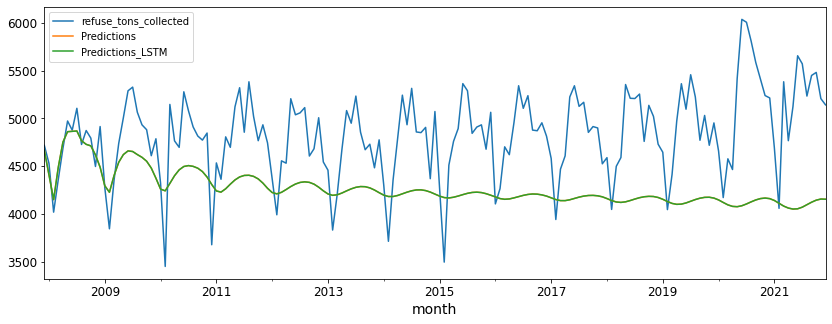

In [42]:
test.plot(figsize = (14,5))

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test['refuse_tons_collected'], test['Predictions_LSTM']))
print(rmse)

1316.3891463840873


## Baseline Metrics
#### Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer.Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [ ]:
model_linear = keras.models.Sequential([
                                        keras.layers.Flatten(input_shape = [12,1]),
                                        keras.layers.Dense(1)
])

model_linear.compile(optimizer='adam', loss='mse')

# fit model
model_linear.fit(generator,epochs=50)

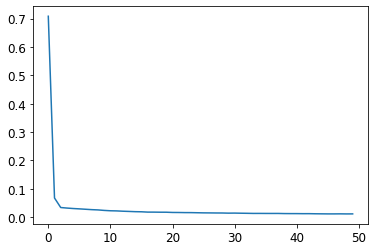

In [ ]:
loss_per_epoch = model_linear.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
#model_linear.predict(last_train_batch)

test_predictions_linear = []

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model_linear.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_linear.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions_linear = scaler.inverse_transform(test_predictions_linear)
test['Predictions_Linear'] = true_predictions_linear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



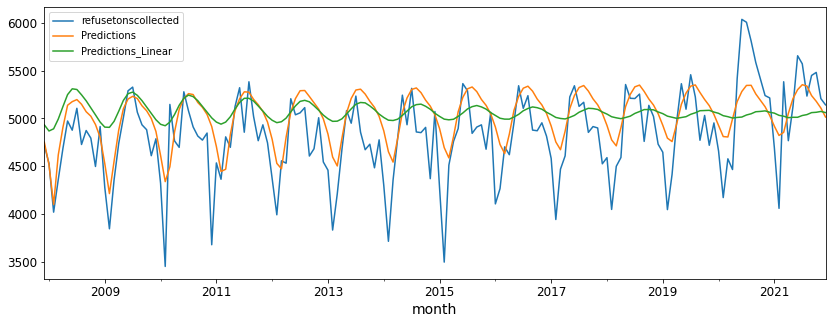

In [ ]:
test.plot(figsize = (14,5))

In [ ]:
rmse_linear = sqrt(mean_squared_error(test['refuse_tons_collected'], test['Predictions_Linear']))
print(rmse_linear)

480.65903132900223
